На основе подготовленной для нейросети таблицы данных с HeadHunter создайте 6 архитектур нейросетей, поэкспериментируйте с гиперпараметрами.
Используйте только числовые данные, текстовые не подавайте.

Результаты в конце проанализируйте.

Перед началом выполнения, пожалуйста, запустите раздел "Подготовка".

## Подготовка

In [1]:
# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [3]:
# скачиваем базу
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/hh_fixed.csv', None, quiet=True)

# Чтение файла базы данных
df = pd.read_csv('hh_fixed.csv', index_col=0)

# Вывод количества резюме и числа признаков
print(df.shape)

df.head(3)

(62967, 12)


,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано


In [4]:
# Настройка номеров столбцов

COL_SEX_AGE     = df.columns.get_loc('Пол, возраст')
COL_SALARY      = df.columns.get_loc('ЗП')
COL_POS_SEEK    = df.columns.get_loc('Ищет работу на должность:')
COL_POS_PREV    = df.columns.get_loc('Последеняя/нынешняя должность')
COL_CITY        = df.columns.get_loc('Город')
COL_EMPL        = df.columns.get_loc('Занятость')
COL_SCHED       = df.columns.get_loc('График')
COL_EXP         = df.columns.get_loc('Опыт (двойное нажатие для полной версии)')
COL_EDU         = df.columns.get_loc('Образование и ВУЗ')
COL_UPDATED     = df.columns.get_loc('Обновление резюме')

In [5]:
# Замена концов строк на пробелы, удаление символа с кодом 0xA0
# обрезка краевых пробелов, приведение к нижнему регистру

def purify(x):
    if isinstance(x, str):                # Если значение - строка:
        x = x.replace('\n', ' ').replace('\xa0', '').strip().lower()
    return x

In [6]:
# Выделение подстроки вида ДД.ММ.ГГГГ и возвращение значения года

def extract_year(x):
    try:
        return int(re.search(r'\d\d.\d\d.(\d{4})', x)[1])   # Ожидается строка вида 'dd.mm.yyyy ...'

    except (IndexError, TypeError, ValueError):
        return 0

In [7]:
### Параметрические данные для функций разбора ###

# Курсы валют для зарплат
currency_rate = {'usd'    : 65.,
                 'kzt'    : 0.17,
                 'грн'    : 2.6,
                 'белруб' : 30.5,
                 'eur'    : 70.,
                 'kgs'    : 0.9,
                 'сум'    : 0.007,
                 'azn'    : 37.5
                }

# Списки и словари для разбиения на классы
# Для ускорения работы добавлен счетчик классов, который будет вычислен ниже

# Список порогов возраста
age_class = [0, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]

# Список порогов опыта работы в месяцах
experience_class = [0, [7, 13, 25, 37, 61, 97, 121, 157, 193, 241]]

# Классы городов
city_class = [0,
              {'москва'          : 0,
               'санкт-петербург' : 1,
               'новосибирск'     : 2,
               'екатеринбург'    : 2,
               'нижний новгород' : 2,
               'казань'          : 2,
               'челябинск'       : 2,
               'омск'            : 2,
               'самара'          : 2,
               'ростов-на-дону'  : 2,
               'уфа'             : 2,
               'красноярск'      : 2,
               'пермь'           : 2,
               'воронеж'         : 2,
               'волгоград'       : 2,
               'прочие города'   : 3
              }]

# Классы занятости
employment_class = [0,
                    {'стажировка'          : 0,
                     'частичная занятость' : 1,
                     'проектная работа'    : 2,
                     'полная занятость'    : 3
                    }]

# Классы графика работы
schedule_class = [0,
                  {'гибкий график'         : 0,
                   'полный день'           : 1,
                   'сменный график'        : 2,
                   'удаленная работа'      : 3
                  }]

# Классы образования
education_class = [0,
                   {'высшее образование'   : 0,
                    'higher education'     : 0,
                    'среднее специальное'  : 1,
                    'неоконченное высшее'  : 2,
                    'среднее образование'  : 3
                   }]


In [8]:
# Вычисление счетчиков для данных разбиения

for class_desc in [age_class,
                   experience_class,
                   city_class,
                   employment_class,
                   schedule_class,
                   education_class]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

In [9]:
 # Получение one hot encoding представления значения класса

def int_to_ohe(arg, class_list):

    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i                       # Интервал найден - назначение класса
            break
    else:                                 # Внимание: for/else
        cls = num_classes - 1             # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [10]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [11]:
# Разбор значений пола, возраста

base_update_year = 2019

def extract_sex_age_years(arg):
    # Ожидается, что значение содержит "мужчина" или "женщина"
    # Если "мужчина" - результат 1., иначе 0.
    sex = 1. if 'муж' in arg else 0.

    try:
        # Выделение года и вычисление возраста
        years = base_update_year - int(re.search(r'\d{4}', arg)[0])

    except (IndexError, TypeError, ValueError):
        # В случае ошибки год равен 0
        years = 0

    return sex, years

In [12]:
# Преобразование значения возраста в one hot encoding

def age_years_to_ohe(arg):
    return int_to_ohe(arg, age_class)

In [13]:
# Преобразование данных об опыте работы в one hot encoding

def experience_months_to_ohe(arg):
    return int_to_ohe(arg, experience_class)

In [14]:
# Разбор значения зарплаты

def extract_salary(arg):
    try:
        # Выделение числа и преобразование к float
        value = float(re.search(r'\d+', arg)[0])

        # Поиск символа валюты в строке, и, если найдено,
        # приведение к рублю по курсу валюты
        for currency, rate in currency_rate.items():
            if currency in arg:
                value *= rate
                break

    except TypeError:
        # Если не получилось выделить число - вернуть 0
        value = 0.

    return value / 1000.                  # В тысячах рублей

In [15]:
# Разбор данных о городe и преобразование в one hot encoding

def extract_city_to_ohe(arg):
    # Определение размерности выходного вектора
    num_classes = city_class[0]

    # Разбивка на слова
    split_array = re.split(r'[ ,.:()?!]', arg)

    # Поиск города в строке и присвоение ему класса
    for word in split_array:
        city_cls = city_class[1].get(word, -1)
        if city_cls >= 0:
            break
    else:                                 # Внимание: for/else
        # Город не в city_class - значит его класс "прочие города"
        city_cls = num_classes - 1

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(city_cls, num_classes)

In [16]:
# Разбор данных о желаемой занятости и преобразование в multi

def extract_employment_to_multi(arg):
    return str_to_multi(arg, employment_class)

In [17]:
# Разбор данных о желаемом графике работы и преобразование в multi

def extract_schedule_to_multi(arg):
    return str_to_multi(arg, schedule_class)

In [18]:
# Разбор данных об образовании и преобразование в multi

def extract_education_to_multi(arg):
    result = str_to_multi(arg, education_class)

    # Поправка: неоконченное высшее не может быть одновременно с высшим
    if result[2] > 0.:
        result[0] = 0.

    return result

In [19]:
# Разбор данных об опыте работы - результат в месяцах

def extract_experience_months(arg):
    try:
        # Выделение количества лет, преобразование в int
        years = int(re.search(r'(\d+)\s+(год.?|лет)', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество лет равно 0
        years = 0

    try:
        # Выделение количества месяцев, преобразование в int
        months = int(re.search(r'(\d+)\s+месяц', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество месяцев равно 0
        months = 0

    # Возврат результата в месяцах
    return years * 12 + months

Функции подготовки выборок

In [20]:
def extract_row_data(row):

    # Извлечение и преобразование данных
    sex, age = extract_sex_age_years(row[COL_SEX_AGE])      # Пол, возраст
    sex_vec = np.array([sex])                               # Пол в виде вектора
    age_ohe = age_years_to_ohe(age)                         # Возраст в one hot encoding
    city_ohe = extract_city_to_ohe(row[COL_CITY])           # Город
    empl_multi = extract_employment_to_multi(row[COL_EMPL]) # Тип занятости
    sсhed_multi = extract_schedule_to_multi(row[COL_SCHED]) # График работы
    edu_multi = extract_education_to_multi(row[COL_EDU])    # Образование
    exp_months = extract_experience_months(row[COL_EXP])    # Опыт работы в месяцах
    exp_ohe = experience_months_to_ohe(exp_months)          # Опыт работы в one hot encoding
    salary = extract_salary(row[COL_SALARY])                # Зарплата в тысячах рублей
    salary_vec = np.array([salary])                         # Зарплата в виде вектора

    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([sex_vec,
                        age_ohe,
                        city_ohe,
                        empl_multi,
                        sсhed_multi,
                        edu_multi,
                        exp_ohe])

    # Возврат входных данных и выходных (зарплаты)
    return x_data, salary_vec


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []

    for row in row_list:
        x, y = extract_row_data(row)
        if y[0] > 0:                      # Данные добавляются, только если есть зарплата
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [21]:
# Формирование выборки из загруженного набора данных
x_train_01, y_train = construct_train_data(df.values)

In [22]:
# Форма наборов параметров и зарплат
print(x_train_01.shape)
print(y_train.shape)

# Пример обработанных данных
n = 0
print(x_train_01[n])
print(y_train[n])

(62967, 39)
(62967, 1)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[40.]


Функция отрисовки графика истории обучения

In [23]:
def plot_history(history):
    plt.plot(history.history['mae'],
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'],
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

In [24]:
# Создание модели нейронной сети с заданными параметрами
def create_model(layers=3, neurons=256, use_dropout=False):
    model = Sequential()
    model.add(BatchNormalization(input_dim=x_train_01.shape[1])) # Добавление слоя нормализации входных данных

    # Цикл по количеству скрытых слоев
    units = neurons
    for _ in range(layers):
        model.add(Dense(units, activation="relu"))
        if use_dropout:
            model.add(Dropout(0.2))
        units = max(8, units // 2)

    # Выходной слой с одной нейронной и линейной активацией
    model.add(Dense(1, activation="linear"))

    model.compile(optimizer=Adam(learning_rate=1e-5), loss="mse", metrics=["mae"])

    return model

In [25]:
# Обучение модели и сохранение результатов в таблицу
def fit_model(models_table, layers=3, neurons=256, use_dropout=False):
    models_table["Количество слоев"].append(layers)
    models_table["Нейронов в первом слое"].append(neurons)
    models_table["Дропаут"].append("Да" if use_dropout else "Нет")

    model = create_model(layers,neurons, use_dropout)

    # Обучение модели на тренировочных данных
    history = model.fit(
        x_train_01,
        y_train,
        epochs=50,
        batch_size=256,
        validation_split=0.15,
        verbose=1,
    )

    pred = model.predict(x_train_01)
    error = mean_absolute_error(pred, y_train)

    models_table["Ошибка на обучающей выборке"].append(history.history["mae"][-1])
    models_table["Ошибка на проверочной выборке"].append(history.history["val_mae"][-1])
    models_table["Средняя абсолютная ошибка"].append(error)


    plot_history(history)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 10898.2920 - mae: 76.5061 - val_loss: 12136.0977 - val_mae: 80.9432
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11098.7490 - mae: 76.0391 - val_loss: 11927.7979 - val_mae: 79.6722
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10664.8369 - mae: 74.3297 - val_loss: 11639.5488 - val_mae: 77.9038
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10710.3447 - mae: 73.1803 - val_loss: 11251.0312 - val_mae: 75.5098
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10251.3496 - mae: 71.0572 - val_loss: 10752.7881 - val_mae: 72.3788
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9328.9805 - mae: 66.9095 - val_loss: 10145.2695 - val_mae: 68.4481
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9229.7686 - mae: 63.5276 - val_loss: 9444.2041 - val_mae: 63.7939
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8379.4512 - mae: 58.8070 - val_loss: 8661.5625 

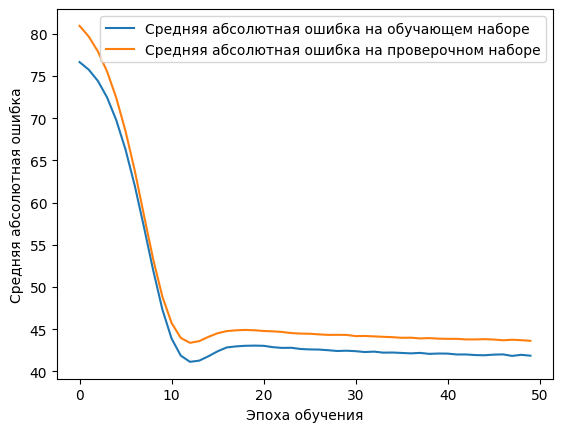

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 10776.4248 - mae: 75.9452 - val_loss: 11696.2676 - val_mae: 78.3152
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9755.1621 - mae: 69.8447 - val_loss: 9594.6582 - val_mae: 64.6770
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7753.9814 - mae: 54.9488 - val_loss: 6926.0391 - val_mae: 48.0156
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6010.0093 - mae: 43.6632 - val_loss: 5605.1104 - val_mae: 44.4106
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5591.6655 - mae: 43.2350 - val_loss: 5315.4395 - val_mae: 45.2619
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4962.2700 - mae: 43.6644 - val_loss: 5212.6904 - val_mae: 45.2206
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4781.7993 - mae: 43.6174 - val_loss: 5150.6172 - val_mae: 45.0042
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4435.6055 - mae: 42.8028 - val_loss: 5108.9966 - val_mae: 44.9354


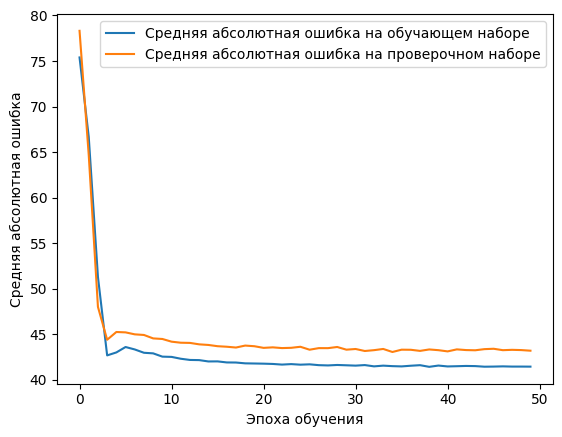

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 10978.8896 - mae: 77.3873 - val_loss: 12216.2363 - val_mae: 81.4379
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 11097.4316 - mae: 77.0820 - val_loss: 12110.0645 - val_mae: 80.7830
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10646.2109 - mae: 76.1509 - val_loss: 11925.2295 - val_mae: 79.6558
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10478.9639 - mae: 74.3367 - val_loss: 11630.9854 - val_mae: 77.8560
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 10521.5879 - mae: 73.2690 - val_loss: 11147.2451 - val_mae: 74.8749
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9791.3555 - mae: 69.5668 - val_loss: 10442.2734 - val_mae: 70.3957
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9690.2363 - mae: 64.7212 - val_loss: 9522.6455 - val_mae: 64.3069
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8733.5088 - mae: 58.7781 - val_loss: 8462.6367 - val_mae:

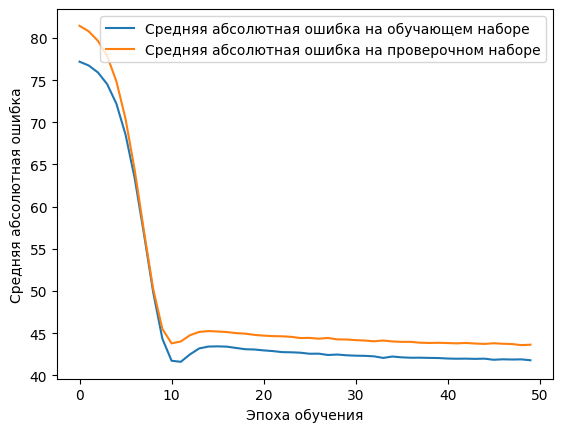

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 11140.9883 - mae: 77.6945 - val_loss: 12242.1084 - val_mae: 81.5996
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10798.2012 - mae: 77.0412 - val_loss: 12193.8672 - val_mae: 81.2992
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 11220.0303 - mae: 77.4575 - val_loss: 12105.9033 - val_mae: 80.7566
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11101.5234 - mae: 76.5826 - val_loss: 11947.6084 - val_mae: 79.7904
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11022.6035 - mae: 75.4762 - val_loss: 11674.6826 - val_mae: 78.1210
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10823.3389 - mae: 73.6201 - val_loss: 11251.6455 - val_mae: 75.4931
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10244.2031 - mae: 71.0777 - val_loss: 10641.3711 - val_mae: 71.5984
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9477.8643 - mae: 66.4548 - val_loss: 9805.6816 - val_m

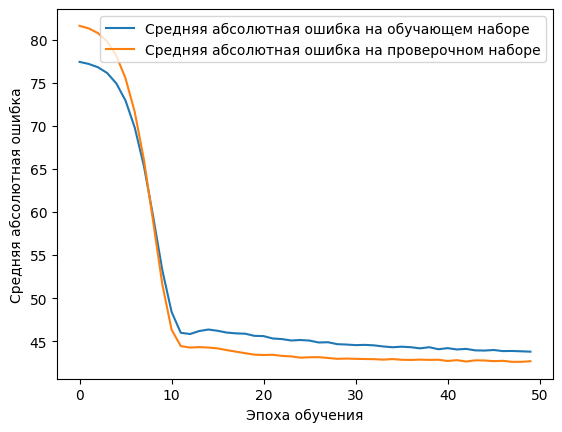

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 11612.8955 - mae: 76.9270 - val_loss: 11728.8086 - val_mae: 78.4584
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10005.4512 - mae: 69.0961 - val_loss: 8376.5645 - val_mae: 56.2539
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6114.9248 - mae: 46.9190 - val_loss: 5623.4712 - val_mae: 45.9645
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5099.5259 - mae: 44.6730 - val_loss: 5377.6699 - val_mae: 46.0254
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4630.3530 - mae: 43.5356 - val_loss: 5238.9600 - val_mae: 45.5038
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4604.9097 - mae: 43.3836 - val_loss: 5149.7339 - val_mae: 44.8191
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4924.3818 - mae: 43.1045 - val_loss: 5082.5522 - val_mae: 44.3640
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4444.2651 - mae: 42.5705 - val_loss: 5034.4150 - val_mae: 44.1854

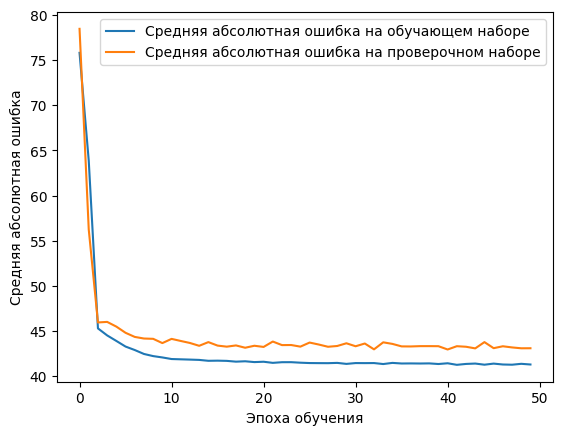

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 10837.8418 - mae: 76.1035 - val_loss: 11796.6025 - val_mae: 78.8764
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9905.4004 - mae: 69.3537 - val_loss: 8461.3857 - val_mae: 56.7659
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6402.0947 - mae: 47.7699 - val_loss: 5651.5264 - val_mae: 45.7826
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5325.9463 - mae: 45.4607 - val_loss: 5404.3940 - val_mae: 45.6788
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4796.5688 - mae: 44.3502 - val_loss: 5276.1196 - val_mae: 45.1459
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4625.2617 - mae: 43.9090 - val_loss: 5191.2598 - val_mae: 44.8609
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5239.3018 - mae: 43.6713 - val_loss: 5136.5605 - val_mae: 44.4854
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5231.2310 - mae: 43.6839 - val_loss: 5084.3174 - val_mae: 44.1662


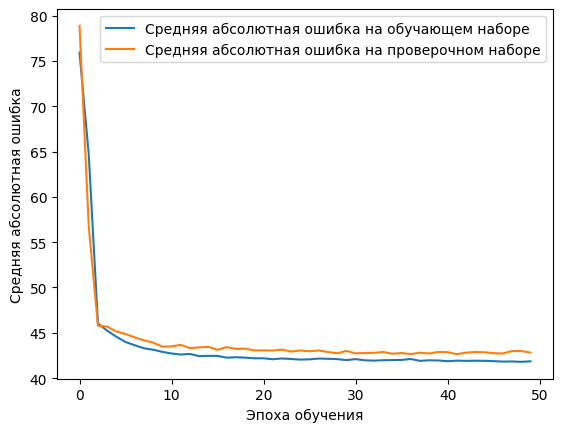

In [26]:
# Инициализация таблицы (словаря списков) для хранения результатов обучения различных моделей
models_table = {
    "Количество слоев": [],
    "Нейронов в первом слое": [],
    "Дропаут": [],
    "Ошибка на обучающей выборке": [],
    "Ошибка на проверочной выборке": [],
    "Средняя абсолютная ошибка": [],
}

# Списки с конфигурациями: разное количество слоев и нейронов
layers_list = [3, 5]
neurons_list = [256, 1024]

# Перебор всех комбинаций количества слоев и числа нейронов
for layers in layers_list:
    for neurons in neurons_list:
        fit_model(models_table, layers, neurons)
        if layers == 5:
            fit_model(models_table, layers, neurons, True)




In [27]:
# Преобразование словаря models_table в объект DataFrame для удобного отображения и анализа результатов
df = pd.DataFrame(models_table)
df

,Количество слоев,Нейронов в первом слое,Дропаут,Ошибка на обучающей выборке,Ошибка на проверочной выборке,Средняя абсолютная ошибка
0,3,256,Нет,41.861385,43.622814,42.234726
1,3,1024,Нет,41.460175,43.209641,41.759740
2,5,256,Нет,41.770905,43.616161,42.225361
3,5,256,Да,43.784782,42.673855,41.160524
4,5,1024,Нет,41.311195,43.110058,41.629120
5,5,1024,Да,41.854374,42.806782,41.297573
